<a href="https://colab.research.google.com/github/luizaclara/KNNtitanic/blob/main/Trabalho_02ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/titanic/data

https://github.com/datasciencedojo/datasets/blob/master/titanic.csv

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

1. Implementação da Função para Seleção dos k Vizinhos Mais Próximos
2. Classificação com Base nos k Vizinhos Mais Próximos

In [2]:
class KNN ():
  def __init__(self,k=3):
    self.k = k #hiperparâmetro

  def fit(self,X,y):
    dataframe = pd.DataFrame(data=X) #dados
    dataframe['value'] = y #target
    self.data = dataframe

  def predict_one(self, x):
    df = self.data.copy()
    df_numeric = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
    x = np.array(x, dtype=float)

    # Calcular distâncias usando a norma Euclidiana
    df['distance'] = np.linalg.norm(df_numeric - x, axis=1)

    # Ordenar distâncias e selecionar os k mais próximos
    df.sort_values(by='distance', inplace=True)
    top_k = df.head(self.k)

    # Pegar a classe majoritária
    class_predict = top_k['value'].value_counts().idxmax()
    return class_predict

  def predict(self, points):
    return [self.predict_one(p) for p in points]




In [3]:
dataframe = pd.read_csv("titanic.csv")


3. Transformação de Features Categóricas em Numéricas

*   As features categóricas Sex e Embarked serão transformadas em numéricas, no entanto, não representam uma ordenação natural. Portanto, será aplicada a técnica de **OneHotEncode** para evitar enviezar o modelo.

4. Análise da Necessidade de Normalização das Features Numéricas

*   Devido à variação de valores das features, será aplicada a **normalização** dos valores.

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [4]:
# Avaliar quantidade de amostras NaN nas features categóricas para dropar ou preencher valores vazios
nan_Embarked = dataframe['Embarked'].isna().sum()
nan_Sex = dataframe['Sex'].isna().sum()
print(f'Embarked: {nan_Embarked} NaN')
print(f'Sex: {nan_Sex} NaN')

# Dropar 2 linhas NaN de Embarked
dataframe.dropna(subset='Embarked', inplace=True)
print(f'Tamanho do dataframe: {len(dataframe)}')

Embarked: 2 NaN
Sex: 0 NaN
Tamanho do dataframe: 889


In [5]:
# Transformar a coluna 'Sex' e 'Embarked' em duas colunas (Passo 3)
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(dataframe[['Sex', 'Embarked']])
encoded_dataframe = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))

# Adicionar a coluna 'PassengerId' ao encoded_dataframe
encoded_dataframe['PassengerId'] = dataframe['PassengerId'].values

# Fazer a concatenação baseada na coluna 'PassengerId'
final_dataframe = pd.merge(dataframe, encoded_dataframe, on='PassengerId')

# Remover as colunas 'Sex' e 'Embarked' do dataframe
final_dataframe.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [6]:
final_dataframe.head(3)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,0.0,0.0,0.0,1.0


*   **PassengerId, Name, Ticket, Cabin** não agregam informações relevantes para o modelo, por se tratarem apenas de identificador, nome, número do ticket e da cabine, respectivamente. Serão dropados do dataset.

*   **Pclass, Sex, Age, SibSp, Parch, Fare e Embarked** serão considerados para o treinamento e predição do modelo.

*   **Survived** é o **target**.

In [7]:
# Dropar features que não serão úteis para o modelo
final_dataframe.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Avaliando a existência de NaN nas features selecionadas
nan_Pclass = final_dataframe['Pclass'].isna().sum()
nan_Age = final_dataframe['Age'].isna().sum()
nan_SibSp = final_dataframe['SibSp'].isna().sum()
nan_Parch = final_dataframe['Parch'].isna().sum()
nan_Fare = final_dataframe['Fare'].isna().sum()
print(f'Pclass: {nan_Pclass} NaN')
print(f'Age: {nan_Age} NaN')
print(f'SibSp: {nan_SibSp} NaN')
print(f'Parch: {nan_Parch} NaN')
print(f'Fare: {nan_Fare} NaN')

# Converter colunas de strings para numérico
final_dataframe['Pclass'] = pd.to_numeric(final_dataframe['Pclass'], errors='coerce')
final_dataframe['SibSp'] = pd.to_numeric(final_dataframe['SibSp'], errors='coerce')
final_dataframe['Parch'] = pd.to_numeric(final_dataframe['Parch'], errors='coerce')

# Preenche a idade com a média das idades nas 177 linhas que estão NaN
final_dataframe['Age'] = final_dataframe['Age'].fillna(dataframe['Age'].mean())

Pclass: 0 NaN
Age: 177 NaN
SibSp: 0 NaN
Parch: 0 NaN
Fare: 0 NaN


In [8]:
# Verificando range dos valores de cada feature
for col in final_dataframe.columns:
    min_val = final_dataframe[col].min()
    max_val = final_dataframe[col].max()
    print(f"Feature '{col}': Min = {min_val}, Max = {max_val}")

# Normalizar (Passo 4)
scaler = MinMaxScaler()
final_dataframe_normalized = pd.DataFrame(scaler.fit_transform(final_dataframe), columns=final_dataframe.columns)

Feature 'Survived': Min = 0, Max = 1
Feature 'Pclass': Min = 1, Max = 3
Feature 'Age': Min = 0.42, Max = 80.0
Feature 'SibSp': Min = 0, Max = 8
Feature 'Parch': Min = 0, Max = 6
Feature 'Fare': Min = 0.0, Max = 512.3292
Feature 'Sex_female': Min = 0.0, Max = 1.0
Feature 'Sex_male': Min = 0.0, Max = 1.0
Feature 'Embarked_C': Min = 0.0, Max = 1.0
Feature 'Embarked_Q': Min = 0.0, Max = 1.0
Feature 'Embarked_S': Min = 0.0, Max = 1.0


5. Seleção de Features com Base na Correlação

*   Será calculada e analisada a **Matriz de Correlação**

*   Como não foram apresentadas correlações muito relevantes entre features de escopos diferentes (sem considerar as geradas pelo OneHotEncoder entre si), resolvemos usar todas essas no nosso modelo.




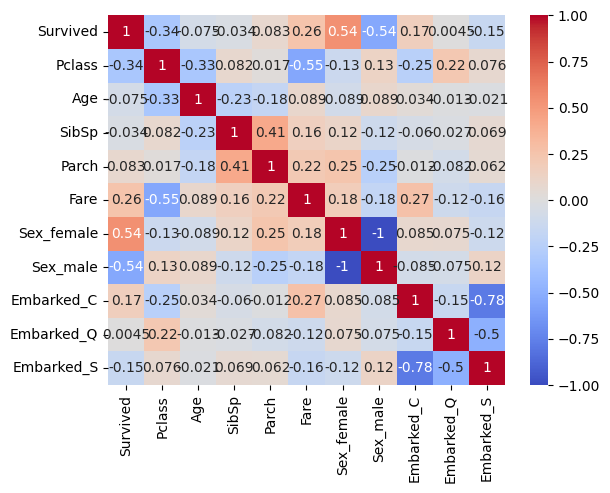

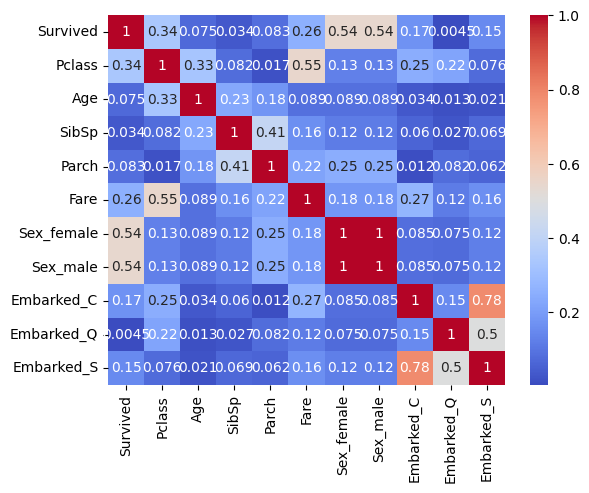

In [9]:
# Passo 5
correlation_matrix = final_dataframe_normalized.corr()
abs_correlation_matrix = correlation_matrix.abs()

# Matriz de Correlação com valores de -1 a 1
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Matriz de Correlação considerando apenas os valores absolutos
sns.heatmap(abs_correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


6. Separação do Dataset em Conjuntos de Treino, Teste e Validação

In [10]:
# Separar features do target (Passo 6)
X = final_dataframe_normalized.drop(columns=['Survived'])
y = final_dataframe_normalized['Survived']

# Treino 75% e teste 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


7. Avaliação de Diferentes Valores de k

8. Avaliação do Melhor Modelo

In [11]:
# Função usando técnica de kfolds para fazer validação do treino
def manual_kfold_cv(X, y, kfolds=10, k_neighbors=3):
    X = np.array(X)
    y = np.array(y)

    fold_size = len(X) // kfolds
    indices = np.arange(len(X))
    np.random.shuffle(indices) #aleatorizar indices

    val_scores = []

    for i in range(kfolds):
        val_indices = indices[i*fold_size:(i+1)*fold_size]
        train_indices = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])

        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_val_fold = X[val_indices]
        y_val_fold = y[val_indices]

        # Instanciar o classificador e treinar com o fold de treino
        classifier = KNN(k=k_neighbors)
        classifier.fit(X_train_fold, y_train_fold)

        # Prever e calcular a acurácia com o fold de validação
        y_val_pred = classifier.predict(X_val_fold)
        val_score = accuracy_score(y_val_fold, y_val_pred)
        val_scores.append(val_score)

        print(f'Acurácia no fold de validação {i+1}: {val_score:.2f}')

    return val_scores

Acurácia no fold de validação 1: 0.86
Acurácia no fold de validação 2: 0.89
Acurácia no fold de validação 3: 0.79
Acurácia no fold de validação 4: 0.73
Acurácia no fold de validação 5: 0.86
Acurácia no fold de validação 6: 0.85
Acurácia no fold de validação 7: 0.77
Acurácia no fold de validação 8: 0.92
Acurácia no fold de validação 9: 0.77
Acurácia no fold de validação 10: 0.77
k=4, Acurácia média: 0.82
Acurácia no fold de validação 1: 0.88
Acurácia no fold de validação 2: 0.86
Acurácia no fold de validação 3: 0.79
Acurácia no fold de validação 4: 0.76
Acurácia no fold de validação 5: 0.79
Acurácia no fold de validação 6: 0.89
Acurácia no fold de validação 7: 0.85
Acurácia no fold de validação 8: 0.80
Acurácia no fold de validação 9: 0.74
Acurácia no fold de validação 10: 0.79
k=8, Acurácia média: 0.82
Acurácia no fold de validação 1: 0.79
Acurácia no fold de validação 2: 0.80
Acurácia no fold de validação 3: 0.83
Acurácia no fold de validação 4: 0.74
Acurácia no fold de validação 5: 0

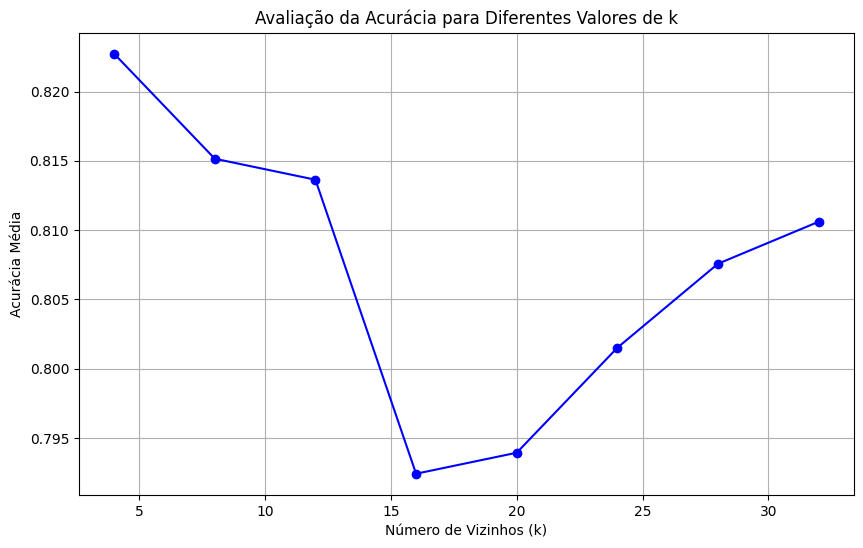

In [12]:
# Avaliar diferentes valores de k (Passo 7)
k_values = range(4, 34, 4)  # Valores de k de 4 a 32, variando de 4 em 4
mean_scores = []

for k in k_values:
    val_scores = manual_kfold_cv(X_train, y_train, kfolds=10, k_neighbors=k)
    mean_score = np.mean(val_scores)
    mean_scores.append(mean_score)
    print(f'k={k}, Acurácia média: {mean_score:.2f}')

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia Média')
plt.title('Avaliação da Acurácia para Diferentes Valores de k')
plt.grid(True)
plt.show()

O melhor valor de k é 4
Acurácia no conjunto de teste: 0.78
Matriz de Confusão:
[[115  26]
 [ 24  58]]
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       141
         1.0       0.69      0.71      0.70        82

    accuracy                           0.78       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.78      0.78      0.78       223



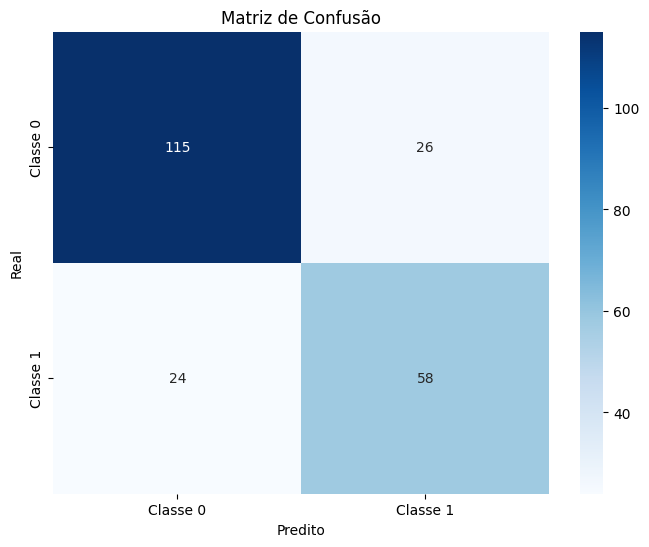

In [13]:
# Passo 8
best_k_index = np.argmax(mean_scores)
best_k = k_values[best_k_index]
print(f'O melhor valor de k é {best_k}')

best_classifier = KNN(k=best_k)
best_classifier.fit(X_train, y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)
# Fazer previsões no conjunto de teste
y_test_pred = best_classifier.predict(X_test)

# Calcular e imprimir métricas
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')
print('Matriz de Confusão:')
print(conf_matrix)
print('Relatório de Classificação:')
print(class_report)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
